In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as pl
import cartopy.crs as ccrs
from cartopy import feature as cfeature

from sklearn.linear_model import Ridge, LinearRegression, RidgeCV
import tqdm
from scipy.stats import spearmanr

import matplotlib.ticker as mticker
import matplotlib.dates as mdates

print("The current version of NumPy is")
print(np.__version__)


The current version of NumPy is
1.20.3


In [2]:
def plot_on_map(lon, lat, arr, cmap, LON0, vmin=None, vmax=None, label="SST"):
    """
    Plots given array using pcolormesh on a map using Plate Carree projection.
    """
    lats, lons = np.meshgrid(lat, lon)

    # set up figure
    LON0 = 180.
    TIKLABFS = 10
    AXLABFS = 12
    map_proj = ccrs.PlateCarree(central_longitude=LON0)
    fig = pl.figure(figsize=[8, 6])
    ax = fig.add_axes([0.10, 0.10, 0.90, 0.80], projection=map_proj)

    # plot array using pcolormesh
    im = ax.pcolormesh(lons, lats, arr, cmap=cmap,
                       vmin=vmin, vmax=vmax,
                       rasterized=True, alpha=0.95,
                       transform=ccrs.PlateCarree()
                       )
    cb = pl.colorbar(im, shrink=0.90)
    #cb.set_label("%s (deg C)" % label, fontsize=AXLABFS)

    # add land colors and coastlines
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor="lightgray",
                                        alpha=0.65, zorder=-1)
    ax.add_feature(land_50m)
    ax.coastlines(linewidth=0.50, color="k", alpha=0.50)

    # set limits of the plot and grid lines
    ax.set_ylim(-66, 66)
    ax.set_xlim(-60., 120)
    gl = ax.gridlines(draw_labels=True, dms=True,
                      x_inline=False, y_inline=False,
                      linestyle="-", linewidth=0.50,
                      color="0.5",alpha=0.15)

    # add axis ticks and set tick label sizes
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
    gl.ylocator = mticker.FixedLocator(np.arange(-65, 66, 15))
    gl.xlabel_style = {"fontsize": TIKLABFS}
    gl.ylabel_style = {"fontsize": TIKLABFS}

    return fig

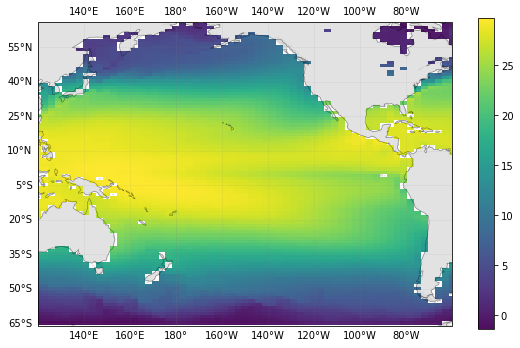

In [3]:
# load data
ds = xr.open_dataset("sst_1979_2020_pacific_coarse.nc")

# extract the SST data and convert it from Kelvin to Celsius
sst = ds.sst# .to_masked_array()
sst = sst - 273.15

# sanity check: plot the average (over time) sst for each location on map
fig = plot_on_map(ds.lon, ds.lat, sst.mean(axis=0).T, cmap="viridis",
                  LON0=180)


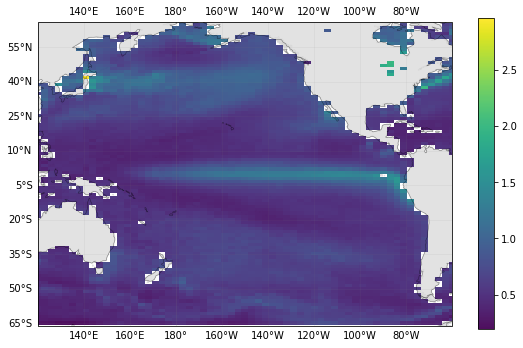

In [4]:
# calculate anomalies
ssta = np.zeros(sst.shape)
for i in range(12):
    ssta[i::12, :, :] = sst[i::12, :, :] - sst[i::12, :, :].mean(axis=0)
mask3d = sst.to_masked_array().mask
ssta = ma.masked_array(ssta, mask=mask3d)

# sanity check: plot the SSTA standard deviation on a map
fig = plot_on_map(ds.lon, ds.lat, ssta.std(axis=0).T,
                  cmap="viridis", LON0=180,
                  label="SSTA Variability")

100%|██████████| 4600/4600 [00:02<00:00, 2016.72it/s]


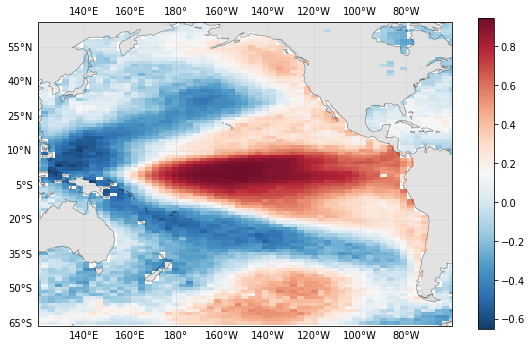

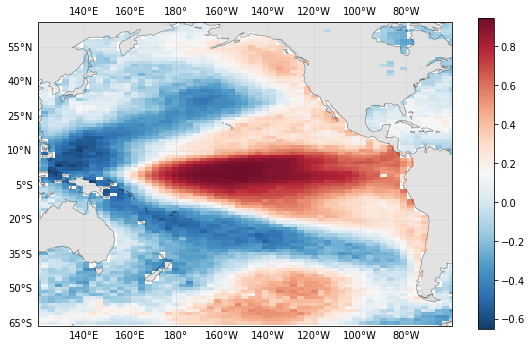

In [5]:
# redo the spearman correlations and plot on map
df = pd.read_csv("oni.csv", index_col=0).squeeze()

# spearmans rho from the actual 3d masked tensor
rho1 = np.zeros((ssta.shape[1], ssta.shape[2]))
y = df.to_numpy()
for i in tqdm.tqdm(range(ssta.shape[1])):
    for j in range(ssta.shape[2]):
        x = ssta[:, i, j]
        r, pval = spearmanr(x, y)
        rho1[i, j] = r
mask2d = ssta.mask.all(axis=0)
rho1_map = ma.masked_array(rho1, mask=mask2d)
fig = plot_on_map(ds.lon, ds.lat, rho1_map.T, cmap="RdBu_r",
                  LON0=180)

ssta_2d = ssta[:, ~ mask2d]
# spearmans rho form the compressed 2D data array
rho2 = np.zeros(ssta_2d.shape[1])
y = df.to_numpy()
for i in tqdm.tqdm(range(ssta_2d.shape[1])):
    x = ssta_2d[:, i]
    r, pval = spearmanr(x, y)
    rho2[i] = r
rho2_map = ma.masked_array(np.zeros(mask2d.shape), mask=mask2d)
rho2_map[~mask2d] = rho2
fig = plot_on_map(ds.lon, ds.lat, rho2_map.T, cmap="RdBu_r",
                  LON0=180)


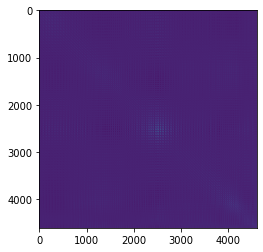

In [6]:
# estimate the covariance matrix
cov = np.cov(ssta_2d, rowvar=False)
pl.imshow(cov)

In [45]:
# compute the eigenvalues and eigenvectors of the covariance matrix
l, ev = np.linalg.eigh(cov)
l, ev = l[::-1], ev[:, ::-1]
print("done")

done


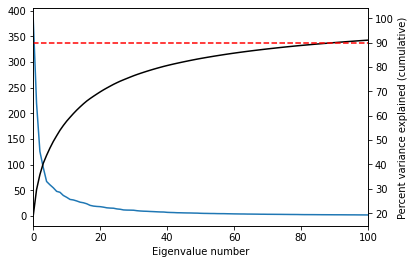

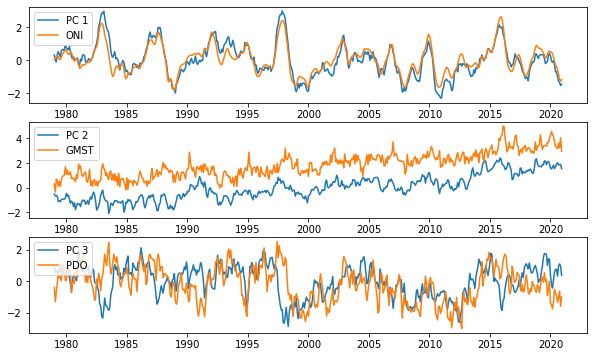

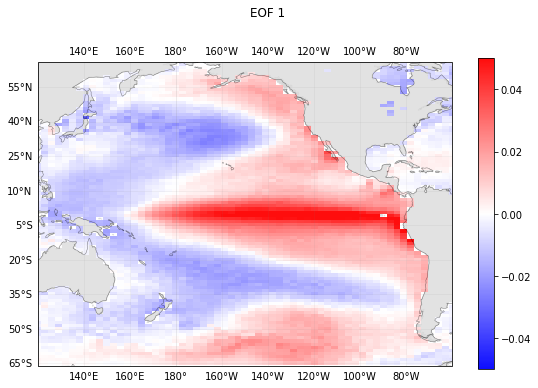

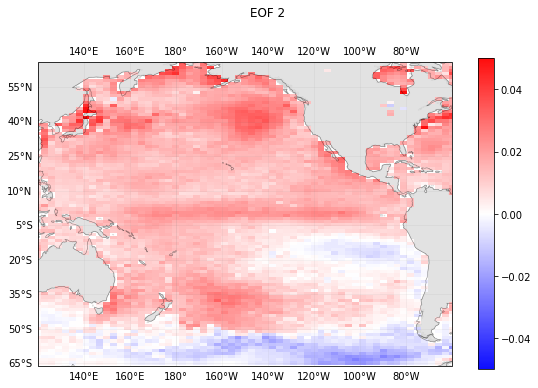

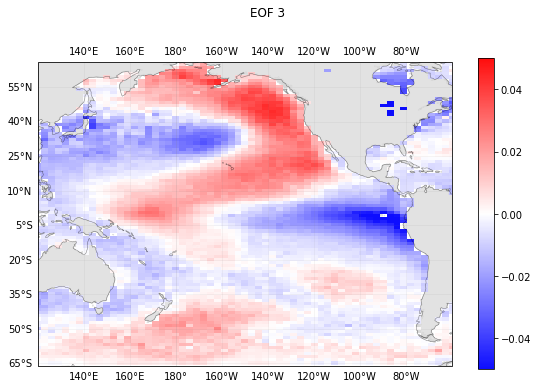

In [47]:
# plot the eigenvalues and check how they are
pl.plot(l)
pl.xlabel("Eigenvalue number")

# compute the cumulative variance explained
pl.twinx()
cum_var_exp = np.cumsum((l / l.sum()) * 100)
pl.plot(cum_var_exp, c="k")
pl.xlabel("Eigenvalue number")
pl.ylabel("Percent variance explained (cumulative)")
pl.axhline(90., ls="--", color="r")
pl.xlim(0, 100)

# visualise the top three principal components
# proj_X_ev1 = X * ev1
fig, axes = pl.subplots(3, 1, figsize=[10, 6])
pc = np.zeros((3, ssta_2d.shape[0]))
for i in range(pc.shape[0]):
    pc[i] = np.matmul(ssta_2d, ev[:, i])
    pc[i] /= pc[i].std()
    axes[i].plot(ds.time, pc[i], label="PC %d" % (i + 1))
    if i == 0:
        df = pd.read_csv("oni.csv", index_col=0).squeeze()
        axes[i].plot(ds.time, df, label="ONI")
    elif i == 1:
        df = pd.read_csv("gmst.csv", index_col=0).squeeze()
        df /= df.std()
        axes[i].plot(ds.time, df, label="GMST")
    elif i == 2:
        df = pd.read_csv("pdo.csv", index_col=0).squeeze()
        axes[i].plot(ds.time, df, label="PDO")        
    axes[i].legend(loc="upper left")

# visualise the top three EOFs
for i in range(3):
    eofs_2d_map = ma.masked_array(np.zeros(mask2d.shape), mask=mask2d)
    eofs_2d_map[~mask2d] = ev[:, i]
    fig = plot_on_map(ds.lon, ds.lat, eofs_2d_map.T,
                      cmap="bwr", LON0=180,
                      vmin=-0.05, vmax = 0.05
                      )
    fig.suptitle("EOF %d" % (i + 1))

In [ ]:
## linear regression model for climate indices explained by Pacific SST

# load climate index
df = pd.read_csv("oni.csv", index_col=0).squeeze()
Y = df.to_numpy().reshape(1, -1).T

# use linear regression but for each location individually
coeffs_linreg = np.zeros(ssta_2d.shape[1])
for i in tqdm.tqdm(range(ssta_2d.shape[1])):
    X = ssta_2d[:, i].reshape(1, -1).T
    reg = LinearRegression().fit(X, Y)
    coeffs_linreg[i] = reg.coef_
coeffs_linreg_map = ma.masked_array(np.zeros(mask2d.shape), mask=mask2d)
coeffs_linreg_map[~mask2d] = coeffs_linreg
fig = plot_on_map(ds.lon, ds.lat, coeffs_linreg_map.T, cmap="RdBu_r",
                  LON0=180)
fig.suptitle("Linear Regression")

In [ ]:
# use ridge regression but for each location individually
coeffs_ridgereg = np.zeros(ssta_2d.shape[1])
for i in tqdm.tqdm(range(coeffs_ridgereg.shape[0])):
    X = ssta_2d[:, i].reshape(1, -1).T
    rreg = RidgeCV(alphas=[1e-3, 1e-2, 1e-1], cv=2).fit(X, Y)
    #rreg = Ridge(alpha=1e0).fit(X, Y)
    coeffs_ridgereg[i] = rreg.coef_
coeffs_ridgereg_map = ma.masked_array(np.zeros(mask2d.shape), mask=mask2d)
coeffs_ridgereg_map[~mask2d] = coeffs_ridgereg
fig = plot_on_map(ds.lon, ds.lat, coeffs_ridgereg_map.T, cmap="RdBu_r",
                  LON0=180)
fig.suptitle("Ridge Regression")

In [ ]:
# use linear regression for all points at the same time
print("linear regression model")
lreg = LinearRegression().fit(ssta_2d, Y)
coeffs_ridgereg_map = ma.masked_array(np.zeros(mask2d.shape), mask=mask2d)
coeffs_ridgereg_map[~mask2d] = lreg.coef_.squeeze()
fig = plot_on_map(ds.lon, ds.lat, coeffs_ridgereg_map.T, cmap="RdBu_r",
                  LON0=180)
fig.suptitle("Linear Regression")
print("done")

# use ridge regression for all points at the same time
print("ridge regression model")
rreg = RidgeCV(alphas=np.logspace(5, 15, num=10), cv=20).fit(ssta_2d, Y)
coeffs_ridgereg_map = ma.masked_array(np.zeros(mask2d.shape), mask=mask2d)
coeffs_ridgereg_map[~mask2d] = rreg.coef_.squeeze()
fig = plot_on_map(ds.lon, ds.lat, coeffs_ridgereg_map.T, cmap="RdBu_r",
                  LON0=180)
fig.suptitle("Ridge Regression")
print("done")

In [ ]:
# plot error over different size of data set
# X := sst_1d_data in our case
# Y := df_oni
# X has 504 rows (time dimension) and 4600 columns (sampling locations)
# 1. choose different subsets of columns from X of different sizes
#    e.g., choose 100 cols, then 200 cols, 300 cols, ... so on  ...
# 2. repeat the regression in each case and get the residual
# 3. plot the residual over sample (i.e. data set) size

def linreg_rss(X, y):
    """
    Fits a linear regression model for y using X and returns residual sum of squares
    """
    reg = LinearRegression().fit(X, y)
    res = y - reg.predict(X)
    return (np.square(res)).sum()

idx = np.arange(1, 21)
rss = np.zeros(len(idx))
for i in idx:
    X = sst_1d_data[:, :(i*100)]
    y = df_oni
    rss[i-1] = linreg_rss(X, y)
print("done")

# plot the results
    
pl.plot(100*idx, rss, "ko-")
pl.xlabel("Size of data")
pl.ylabel("Residual sum of squares")